In [1]:
# 数据下载，分割训练集测试集
import warnings

import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.exceptions import ConvergenceWarning
from sklearn.neural_network import MLPClassifier
from keras.utils import np_utils
from keras.models import Sequential
from sklearn.metrics import accuracy_score, roc_auc_score, mutual_info_score
from sklearn.preprocessing import LabelEncoder
from torchvision import datasets, transforms
import torch
import os
import pickle
from scipy.stats import levy_stable

try:
    devices = tf.config.experimental.list_physical_devices('GPU')
    print(devices)
    tf.config.experimental.set_memory_growth(devices[0], True)
    tf.config.experimental.set_memory_growth(devices[1], True)
except:
    print('未使用GPU')

# 神经网络模型搭建
from tensorflow import keras
from tensorflow.keras.layers import Dense


from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import backend as k
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam


[]
未使用GPU


In [2]:
b = 64
width = 3
depth = 3
lr = 0.001

In [3]:
def stable_noise(img, alpha, beta, scale):
    '''
    此函数用将产生的stable噪声加到图片上
    传入:
        img   :  原图
        alpha  :  shape parameter
        beta :  symmetric parameter
        scale : scale parameter
        random_state : 随机数种子
    返回:
        stable_out : 噪声处理后的图片
        noise        : 对应的噪声
    '''
    # 产生stable noise
    noise = levy_stable.rvs(alpha=alpha,beta=beta,scale=scale,size=img.shape)
    # 将噪声和图片叠加
    stable_out = img + noise
    # 将超过 255 的置 255，低于 0 的置 0
    stable_out = np.clip(stable_out, 0, 255)
    # 取整
    stable_out = np.uint(stable_out)
    return stable_out, noise # 这里也会返回噪声，注意返回值

def stable_noise_hundred(inputs, alpha, beta=0, scale=30):
    '''
    对数据集中的行添加噪声
    每一百行一起添加噪声
    inputs:整个数据集
    alpha, beta, scale : 需要添加噪声的alpha, beta, scale
    '''
    noisy_data = np.zeros(inputs.shape)
    num_samples = np.shape(inputs)[0]
    k = np.arange(0,num_samples,100)
    for i in k:
        temp = inputs[i:i+100]
        temp_noise = stable_noise(temp, alpha, beta, scale)[0]
        noisy_data[i:i+100] = temp_noise
    return noisy_data

def stable_noise_mixture_hundred(inputs, alphas, beta, scale):
    '''
    此函数用将产生的stable噪声加到图片上。mixture：对每个像素随机加不同alpha的噪声。
    传入:
        img   :  原图
        alpha  :  shape parameter
        beta :  symmetric parameter
        scale : scale parameter
        random_state : 随机数种子
    返回:
        stable_out : 噪声处理后的图片
        noise        : 对应的噪声
    '''
    noisy_data = np.zeros(inputs.shape)
    num_samples = np.shape(inputs)[0]
    k = np.arange(0,num_samples,10000)
    for i in k:
        temp = inputs[i:i+10000]
        alpha_c = np.random.choice(alphas, size=temp.shape)
        # 产生stable noise
        noise = levy_stable.rvs(alpha=alpha_c,beta=beta,scale=scale)
        # 将噪声和图片叠加
        stable_out = temp + noise
        # 将超过 255 的置 255，低于 0 的置 0
        stable_out = np.clip(stable_out, 0, 255)
        # 取整
        stable_out = np.uint(stable_out)
        noisy_data[i:i+10000] = stable_out
    return noisy_data

In [4]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X_tr, X_te = X[:60000], X[60000:]
y_tr, y_te = y[:60000], y[60000:]

sigma= 0.25
(660000, 784)
(660000,)
(660000, 784)
(660000, 10)
(660000, 1, 784)
(660000, 1, 10)
num_iterations: 10000 num_epochs: 1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 3)              2355      
_________________________________________________________________
dense_1 (Dense)              (None, 1, 10)             40        
Total params: 2,395
Trainable params: 2,395
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
10313/10313 [==============================] - 59s 6ms/step - loss: 1.0914 - accuracy: 0.6209 - val_loss: 0.7486 - val_accuracy: 0.7669
Epoch 2/20
10313/10313 [==============================] - 46s 4ms/step - loss: 0.7938 - accuracy: 0.7405 - val_loss: 0.7258 - val_accuracy: 0.7767
Epoch 3/20
10313/10313 [==============================] - 44s 4ms/step - loss: 0.7617

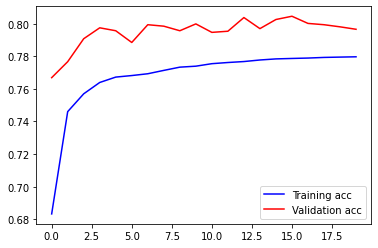

Epoch 1/20
10313/10313 [==============================] - 44s 4ms/step - loss: 0.6933 - accuracy: 0.7796 - val_loss: 0.6543 - val_accuracy: 0.8007
Epoch 2/20
10313/10313 [==============================] - 42s 4ms/step - loss: 0.6930 - accuracy: 0.7802 - val_loss: 0.6464 - val_accuracy: 0.7990
Epoch 3/20
10313/10313 [==============================] - 43s 4ms/step - loss: 0.6925 - accuracy: 0.7800 - val_loss: 0.6525 - val_accuracy: 0.7936
Epoch 4/20
  735/10313 [=>............................] - ETA: 38s - loss: 0.6852 - accuracy: 0.7802

KeyboardInterrupt: 

In [5]:
sigma = 0.25
alpha_train = 2
noise_scale = np.sqrt(0.5) * sigma * 255
print('sigma=', sigma)

alpha_train = float(alpha_train)
# 计算noise的scale
X_train = X_tr
aug_times_train = 10
X_noise = np.tile(X_tr,(aug_times_train,1))
X_noise = stable_noise_hundred(X_noise, alpha=alpha_train, beta=0, scale=noise_scale)
# X_train = clean + noise
X_train = np.vstack((X_tr, X_noise))

X_train = np.asarray(X_train) / 255.
X_train = (X_train - np.mean(X_train)) / np.std(X_train)
# y_train:
y_train = np.tile(y_tr, aug_times_train+1)

print(np.shape(X_train))
print(np.shape(y_train))

num_classes = 10
encoder = LabelEncoder()

y_train = encoder.fit_transform(y_train)

# one hot encoding
y_train = np_utils.to_categorical(y_train, num_classes)

X_train = np.array(X_train)
y_train = np.array(y_train)
print(np.shape(X_train))
print(np.shape(y_train))

X_train = X_train.reshape(-1,1,784)
y_train = y_train.reshape(-1,1,10)

print(np.shape(X_train))
print(np.shape(y_train))

num_classes = 10

model = Sequential()
# model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), activation="relu", input_shape=(28, 28, 1) ))
for i in range(depth-2):
    model.add(Dense(width, activation='relu',input_shape=(1,784)))
model.add(Dense(10, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=Adam(lr=lr),
                metrics=['accuracy'])

nb_iterations = 10000
batch_size = b
nb_epochs = np.ceil(nb_iterations * (batch_size / X_train.shape[0])).astype(int)
print('num_iterations:', nb_iterations, 'num_epochs:', nb_epochs)
print(model.summary())

X_test = np.asarray(X_te) / 255.
X_test = (X_test - np.mean(X_test)) / np.std(X_test)
num_classes = 10
encoder = LabelEncoder()

y_test = encoder.fit_transform(y_te)

# one hot encoding
y_test = np_utils.to_categorical(y_test, num_classes)

X_test = np.array(X_test)
y_test = np.array(y_test)
X_test = X_test.reshape(-1,1,784)
y_test = y_test.reshape(-1,1,10)
history = model.fit(X_train, y_train, batch_size = b, epochs = 20, validation_data=(X_test, y_test))



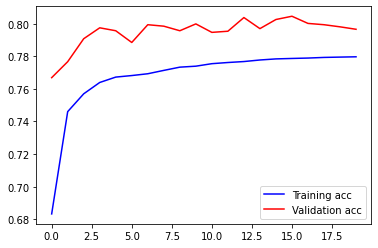

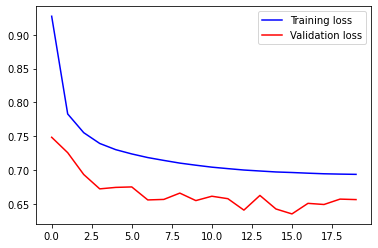

In [6]:
epochs=range(len(history.history['accuracy']))
plt.plot(epochs,history.history['accuracy'],'b',label='Training acc')
plt.plot(epochs,history.history['val_accuracy'],'r',label='Validation acc')
plt.legend()
plt.show()

plt.plot(epochs,history.history['loss'],'b',label='Training loss')
plt.plot(epochs,history.history['val_loss'],'r',label='Validation loss')
plt.legend()
plt.show()

In [7]:
sigma = 0.1
alpha_train = 1
noise_scale = np.sqrt(0.5) * sigma * 255
print('sigma=', sigma)

alpha_train = float(alpha_train)
# 计算noise的scale
X_train = X_tr
aug_times_train = 10
X_noise = np.tile(X_tr,(aug_times_train,1))
X_noise = stable_noise_hundred(X_noise, alpha=alpha_train, beta=0, scale=noise_scale)
# X_train = clean + noise
X_train = np.vstack((X_tr, X_noise))

X_train = np.asarray(X_train) / 255.
X_train = (X_train - np.mean(X_train)) / np.std(X_train)
# y_train:
y_train = np.tile(y_tr, aug_times_train+1)

print(np.shape(X_train))
print(np.shape(y_train))

num_classes = 10
encoder = LabelEncoder()

y_train = encoder.fit_transform(y_train)

# one hot encoding
y_train = np_utils.to_categorical(y_train, num_classes)

X_train = np.array(X_train)
y_train = np.array(y_train)
print(np.shape(X_train))
print(np.shape(y_train))

X_train = X_train.reshape(-1,1,784)
y_train = y_train.reshape(-1,1,10)

print(np.shape(X_train))
print(np.shape(y_train))

num_classes = 10

model = Sequential()
# model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), activation="relu", input_shape=(28, 28, 1) ))
for i in range(depth-2):
    model.add(Dense(width, activation='relu',input_shape=(1,784)))
model.add(Dense(10, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=Adam(lr=lr),
                metrics=['accuracy'])

nb_iterations = 10000
batch_size = b
nb_epochs = np.ceil(nb_iterations * (batch_size / X_train.shape[0])).astype(int)
print('num_iterations:', nb_iterations, 'num_epochs:', nb_epochs)
print(model.summary())

X_test = np.asarray(X_te) / 255.
X_test = (X_test - np.mean(X_test)) / np.std(X_test)
num_classes = 10
encoder = LabelEncoder()

y_test = encoder.fit_transform(y_te)

# one hot encoding
y_test = np_utils.to_categorical(y_test, num_classes)

X_test = np.array(X_test)
y_test = np.array(y_test)
X_test = X_test.reshape(-1,1,784)
y_test = y_test.reshape(-1,1,10)
history2 = model.fit(X_train, y_train, batch_size = b, epochs = 20, validation_data=(X_test, y_test))



sigma= 0.1
(660000, 784)
(660000,)
(660000, 784)
(660000, 10)
(660000, 1, 784)
(660000, 1, 10)
num_iterations: 10000 num_epochs: 1
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1, 3)              2355      
_________________________________________________________________
dense_3 (Dense)              (None, 1, 10)             40        
Total params: 2,395
Trainable params: 2,395
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
10313/10313 [==============================] - 38s 4ms/step - loss: 1.0320 - accuracy: 0.6514 - val_loss: 0.7275 - val_accuracy: 0.7727
Epoch 2/20
10313/10313 [==============================] - 39s 4ms/step - loss: 0.7854 - accuracy: 0.7474 - val_loss: 0.7222 - val_accuracy: 0.7784
Epoch 3/20
10313/10313 [==============================] - 39s 4ms/step - loss: 0.768

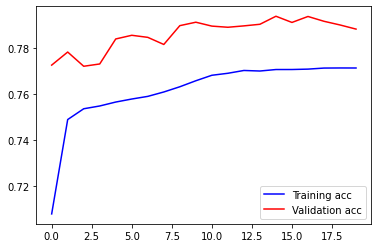

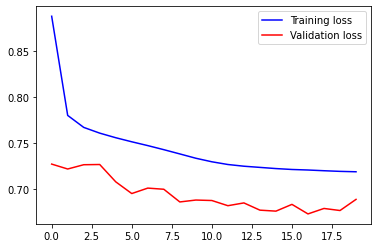

In [8]:
epochs=range(len(history2.history['accuracy']))
plt.plot(epochs,history2.history['accuracy'],'b',label='Training acc')
plt.plot(epochs,history2.history['val_accuracy'],'r',label='Validation acc')
plt.legend()
plt.show()

plt.plot(epochs,history2.history['loss'],'b',label='Training loss')
plt.plot(epochs,history2.history['val_loss'],'r',label='Validation loss')
plt.legend()
plt.show()

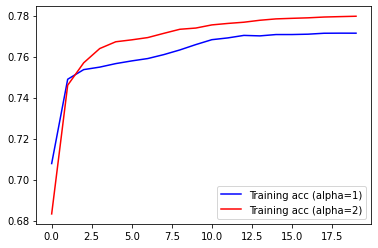

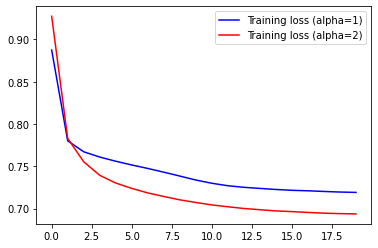

In [11]:
plt.plot(epochs,history2.history['accuracy'],'b',label='Training acc (alpha=1)')
plt.plot(epochs,history.history['accuracy'],'r',label='Training acc (alpha=2)')
plt.legend()
plt.show()

plt.plot(epochs,history2.history['loss'],'b',label='Training loss (alpha=1)')
plt.plot(epochs,history.history['loss'],'r',label='Training loss (alpha=2)')
plt.legend()
plt.show()

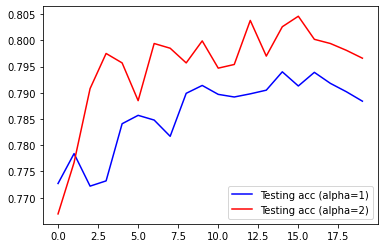

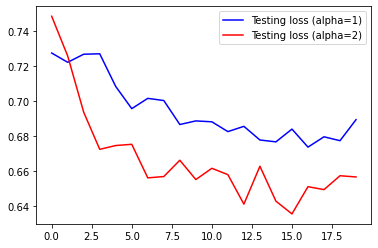

In [10]:
plt.plot(epochs,history2.history['val_accuracy'],'b',label='Testing acc (alpha=1)')
plt.plot(epochs,history.history['val_accuracy'],'r',label='Testing acc (alpha=2)')
plt.legend()
plt.show()

plt.plot(epochs,history2.history['val_loss'],'b',label='Testing loss (alpha=1)')
plt.plot(epochs,history.history['val_loss'],'r',label='Testing loss (alpha=2)')
plt.legend()
plt.show()